In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
import neural.binary_modules as bm
import neural.utilities as utils

### Training tools

In [11]:
def plot_values(values, subplot=None, **kwargs):
    # clear_output(True)
    if subplot:
        plt.subplot(*subplot)
  
    plt.plot(np.arange(len(values)) + 1, values, **kwargs)
    plt.xlabel("n_epoch")
    plt.legend()
    # plt.show()


def matrix_accuracy(A: np.array, B: np.array):
    assert A.shape == B.shape
    return 1 - np.sum(np.abs(A - B)) / A.size


def density(A: np.array):
    return A.sum() / np.size(A)

In [59]:
def train_over_matrix(matrix, model, criterion, optimizer,
                      batch_size=16, n_epochs=10, draw_plots=True):
    
    train_loader = DataLoader(utils.matrix_to_ids(matrix), batch_size=batch_size)
    losses_per_epoch = list()
    fact_acc = list()
    intermediate_user_factors = list()
    intermediate_item_factors = list()
    user_emb_grads = list()       # user_embedding.weight
    item_emb_grads = list()       # item_embedding.weight
    approx_densities = list()

    for epoch in tqdm(range(n_epochs)):
        losses_per_batch = list()

        for i, batch in enumerate(train_loader):
            model_output = model(batch)
            target = batch[:, 2].float()

            optimizer.zero_grad()
            train_loss = criterion(model_output, target)
            train_loss.backward()
            user_emb_grads.append(torch.norm(list(model.parameters())[0].grad))
            item_emb_grads.append(torch.norm(list(model.parameters())[1].grad))
            optimizer.step()
            losses_per_batch.append(train_loss.detach().numpy())
            
        losses_per_epoch.append(np.array(losses_per_batch).mean())

        if draw_plots:
            clear_output(True)
            plt.figure(figsize=(12, 11))
            plot_values(losses_per_epoch, subplot=(3, 2, 1), label=str(criterion), color="green")
            plot_values(fact_acc, subplot=(3, 2, 2), label="Factorization accuracy", color="maroon")
            plot_values(user_emb_grads, subplot=(3, 2, 3), label="User gradient magnitude", color="orange")
            plot_values(item_emb_grads, subplot=(3, 2, 4), label="Item gradient magnitude", color="orange")
            plot_values(approx_densities, subplot=(3, 2, 5), label="Approx. density", color="indigo")
            plt.show()
        
        if epoch % 10 == 0:    # was 10
            # Calculating factorization error
            # temp_user_factor = (np.sign(model.user_embedding_b.weight.detach().clone().numpy()) + 1) / 2
            # temp_item_factor = (np.sign(model.item_embedding_b.weight.detach().clone().numpy()) + 1) / 2
            temp_user_factor, temp_item_factor = model.get_factors()
            approx_matrix = utils.bin_matmul_1(temp_user_factor, temp_item_factor.T)
            fact_acc.append(matrix_accuracy(approx_matrix, matrix.numpy()))
            approx_densities.append(density(approx_matrix))
            
        if epoch % 10 == 0:   # was 20
            intermediate_user_factors.append(temp_user_factor)
            intermediate_item_factors.append(temp_item_factor)
            

    user_bin_factor, item_bin_factor = model.get_factors()

    output = {
        "user_bin_factor": user_bin_factor,
        "item_bin_factor": item_bin_factor,
        "losses_per_epoch": losses_per_epoch,
        "fact_acc": fact_acc,
        "iuf": intermediate_user_factors,
        "iif": intermediate_item_factors,
        "user_emb_grads": user_emb_grads,
        "item_emb_grads": item_emb_grads
    }

    return output

### Experiments
#### 1.) Test different output activations (arbitrary matrix)

In [31]:
from tqdm.notebook import tqdm

n_users = 6
n_items = 6
emb_size = 4
hid_size = 32
activations = ["shifted_sigmoid", "maxpool", "tanh"]      # activations to try

matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(n_users, dtype=torch.int8)

criterion = nn.MSELoss()
accuracy_scores = list()
losses = list()
approx_densities = list()

for act in tqdm(activations):
    
    model = bm.NeuralBMF_large(
        n_users=n_users,
        n_items=n_items,
        embedding_dim=emb_size,
        hidden_dim=hid_size,
        output_act=act,
        init_weights=True,
        tanh_coef=5            # coefficient for tanh is fixed
    )

    optimizer = torch.optim.Adam(model.parameters())

    output = train_over_matrix(
        matrix=matrix,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        batch_size=36, n_epochs=160,
        draw_plots=False               # no dynamic plotting here
    )

    accuracy_scores.append(output["fact_acc"])
    losses.append(output["losses_per_epoch"])
    approx_densities.append([density(utils.bin_matmul_1(u, i.T)) for u, i in zip(output["iuf"], output["iif"])])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

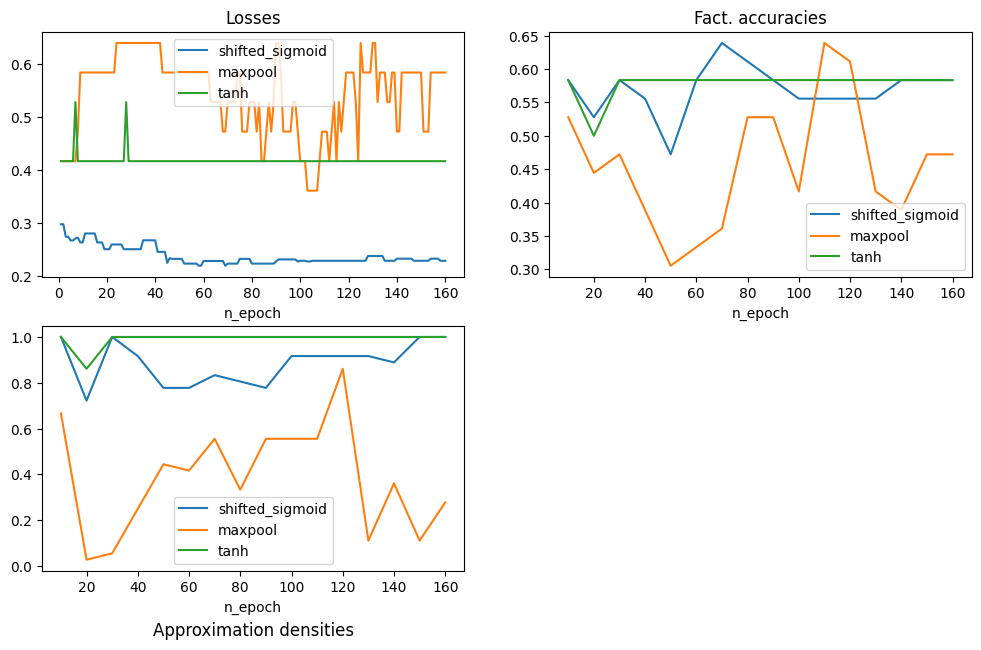

In [40]:
plt.figure(figsize=(12, 7))

for i in range(3):
    plt.subplot(2, 2, 1)
    plt.title("Losses")
    plt.plot(np.arange(len(losses[i])) + 1, losses[i], label=f"{activations[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Fact. accuracies")
    plt.plot((np.arange(len(accuracy_scores[i])) + 1) * 10, accuracy_scores[i], label=f"{activations[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("Approximation densities", y=-0.3)
    plt.plot((np.arange(len(approx_densities[i])) + 1) * 10, approx_densities[i], label=f"{activations[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

plt.show()

#### 2.) Same for identity matrix

In [47]:
from tqdm.notebook import tqdm

n_users = 6
n_items = 6
emb_size = 4
hid_size = 32
activations = ["shifted_sigmoid", "maxpool", "tanh"]      # activations to try

# matrix = utils.get_binary_tensor((n_users, n_items))
matrix = torch.eye(n_users, dtype=torch.int8)

criterion = nn.MSELoss()
accuracy_scores = list()
losses = list()
approx_densities = list()

for act in tqdm(activations):
    
    model = bm.NeuralBMF_large(
        n_users=n_users,
        n_items=n_items,
        embedding_dim=emb_size,
        hidden_dim=hid_size,
        output_act=act,
        init_weights=True,
        tanh_coef=10            # coefficient for tanh is fixed
    )

    optimizer = torch.optim.Adam(model.parameters())

    output = train_over_matrix(
        matrix=matrix,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        batch_size=36, n_epochs=160,
        draw_plots=False               # no dynamic plotting here
    )

    accuracy_scores.append(output["fact_acc"])
    losses.append(output["losses_per_epoch"])
    approx_densities.append([density(utils.bin_matmul_1(u, i.T)) for u, i in zip(output["iuf"], output["iif"])])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

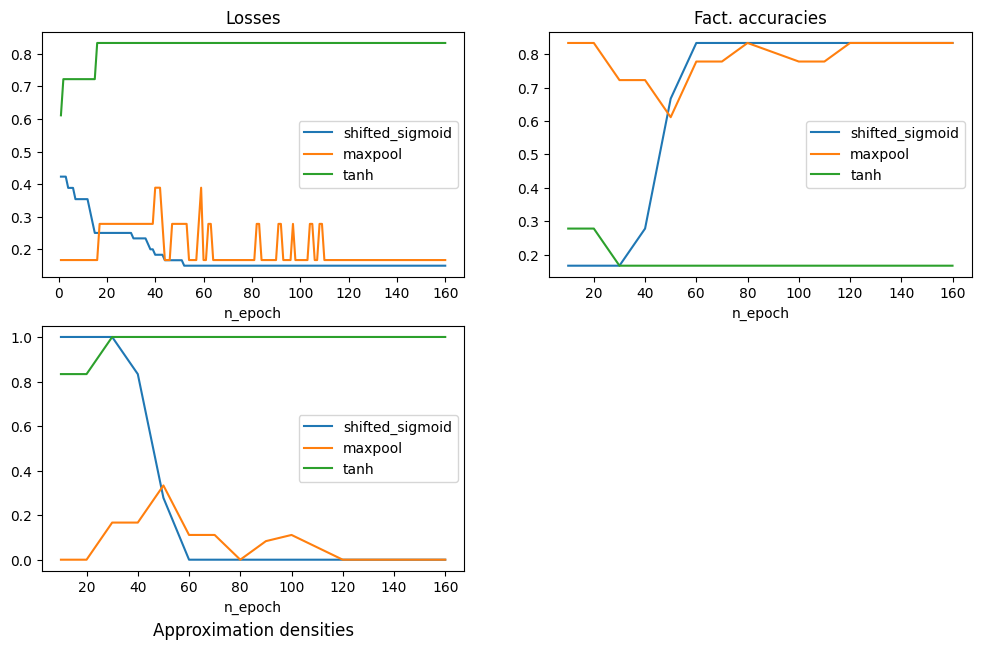

In [48]:
plt.figure(figsize=(12, 7))

for i in range(3):
    plt.subplot(2, 2, 1)
    plt.title("Losses")
    plt.plot(np.arange(len(losses[i])) + 1, losses[i], label=f"{activations[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Fact. accuracies")
    plt.plot((np.arange(len(accuracy_scores[i])) + 1) * 10, accuracy_scores[i], label=f"{activations[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("Approximation densities", y=-0.3)
    plt.plot((np.arange(len(approx_densities[i])) + 1) * 10, approx_densities[i], label=f"{activations[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

plt.show()

NOTE: видим, что сигмоида и maxpool на единичной матрице учатся её занулять. Тангенс почему-то наоборот превращает все в единички.
UPD: с тангенсом скорее всего так из-за того, что он не сдвинут. Как сдвину - по идее будет вести себя как сигмоида

#### 3.) Test different hidden sizes for (shifted_sigmoid)

In [50]:
from tqdm.notebook import tqdm

n_users = 6
n_items = 6
emb_size = 4
hid_sizes = [8, 16, 32, 64, 128]
act = "shifted_sigmoid"

matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(n_users, dtype=torch.int8)

criterion = nn.MSELoss()
accuracy_scores = list()
losses = list()
approx_densities = list()

for hid_size in tqdm(hid_sizes):
    
    model = bm.NeuralBMF_large(
        n_users=n_users,
        n_items=n_items,
        embedding_dim=emb_size,
        hidden_dim=hid_size,
        output_act=act,
        init_weights=True,
        tanh_coef=5            # coefficient for tanh is fixed
    )

    optimizer = torch.optim.Adam(model.parameters())

    output = train_over_matrix(
        matrix=matrix,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        batch_size=36, n_epochs=160,
        draw_plots=False               # no dynamic plotting here
    )

    accuracy_scores.append(output["fact_acc"])
    losses.append(output["losses_per_epoch"])
    approx_densities.append([density(utils.bin_matmul_1(u, i.T)) for u, i in zip(output["iuf"], output["iif"])])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

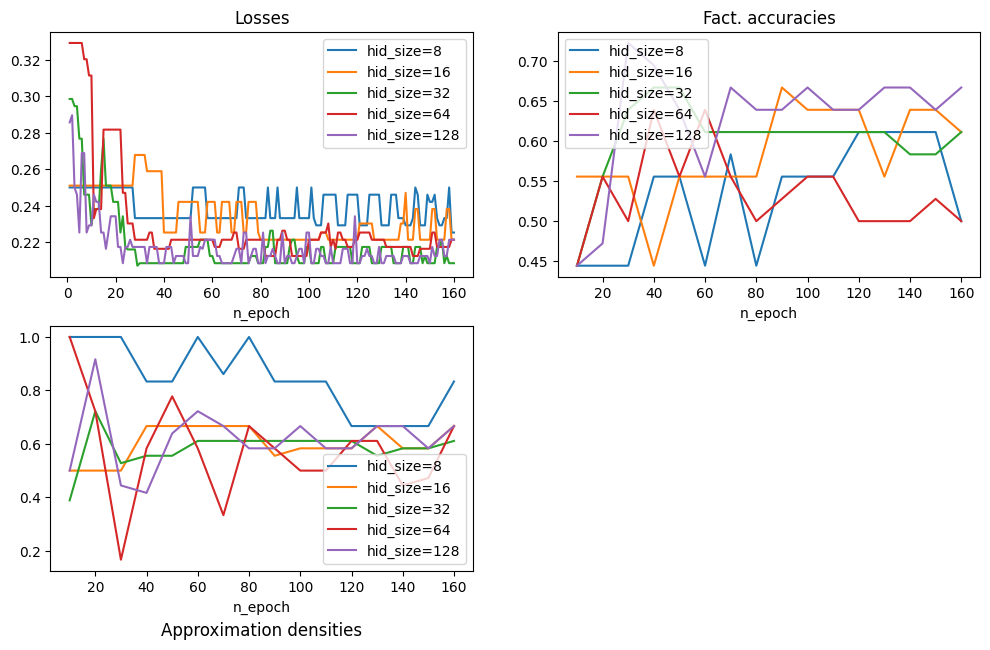

In [51]:
plt.figure(figsize=(12, 7))

for i in range(len(hid_sizes)):
    plt.subplot(2, 2, 1)
    plt.title("Losses")
    plt.plot(np.arange(len(losses[i])) + 1, losses[i], label=f"hid_size={hid_sizes[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Fact. accuracies")
    plt.plot((np.arange(len(accuracy_scores[i])) + 1) * 10, accuracy_scores[i], label=f"hid_size={hid_sizes[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("Approximation densities", y=-0.3)
    plt.plot((np.arange(len(approx_densities[i])) + 1) * 10, approx_densities[i], label=f"hid_size={hid_sizes[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

plt.show()

NOTE: кажется, что с расширением скрытого слоя мы наблюдаем тенденцию на рост качества

#### 4.) Same for identity matrix

In [52]:
from tqdm.notebook import tqdm

n_users = 6
n_items = 6
emb_size = 4
hid_sizes = [8, 16, 32, 64, 128]
act = "shifted_sigmoid"

# matrix = utils.get_binary_tensor((n_users, n_items))
matrix = torch.eye(n_users, dtype=torch.int8)

criterion = nn.MSELoss()
accuracy_scores = list()
losses = list()
approx_densities = list()

for hid_size in tqdm(hid_sizes):
    
    model = bm.NeuralBMF_large(
        n_users=n_users,
        n_items=n_items,
        embedding_dim=emb_size,
        hidden_dim=hid_size,
        output_act=act,
        init_weights=True,
        tanh_coef=5            # coefficient for tanh is fixed
    )

    optimizer = torch.optim.Adam(model.parameters())

    output = train_over_matrix(
        matrix=matrix,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        batch_size=36, n_epochs=160,
        draw_plots=False               # no dynamic plotting here
    )

    accuracy_scores.append(output["fact_acc"])
    losses.append(output["losses_per_epoch"])
    approx_densities.append([density(utils.bin_matmul_1(u, i.T)) for u, i in zip(output["iuf"], output["iif"])])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

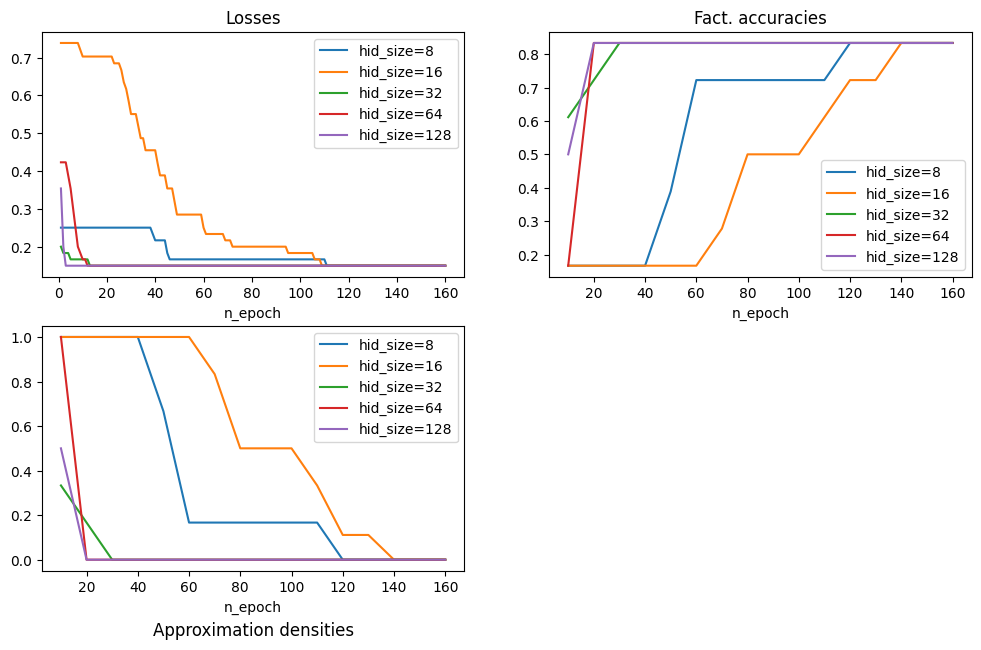

In [53]:
plt.figure(figsize=(12, 7))

for i in range(len(hid_sizes)):
    plt.subplot(2, 2, 1)
    plt.title("Losses")
    plt.plot(np.arange(len(losses[i])) + 1, losses[i], label=f"hid_size={hid_sizes[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Fact. accuracies")
    plt.plot((np.arange(len(accuracy_scores[i])) + 1) * 10, accuracy_scores[i], label=f"hid_size={hid_sizes[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("Approximation densities", y=-0.3)
    plt.plot((np.arange(len(approx_densities[i])) + 1) * 10, approx_densities[i], label=f"hid_size={hid_sizes[i]}")
    plt.xlabel("n_epoch")
    plt.legend()

plt.show()

NOTE: единичную матрице, к сожалению, все сигмоидные модели просто рано или поздно зануляют

### Close-up
Смотрим на модель с сигмоидой

In [60]:
n_users = 6
n_items = 6
emb_size = 4
hid_size = 32

matrix = utils.get_binary_tensor((n_users, n_items))
# matrix = torch.eye(n_users, dtype=torch.int8)
criterion = nn.MSELoss()

model = bm.NeuralBMF_large(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=emb_size,
    hidden_dim=hid_size,
    output_act="shifted_sigmoid",
    init_weights=True,
    tanh_coef=5            # coefficient for tanh is fixed
)

optimizer = torch.optim.Adam(model.parameters())

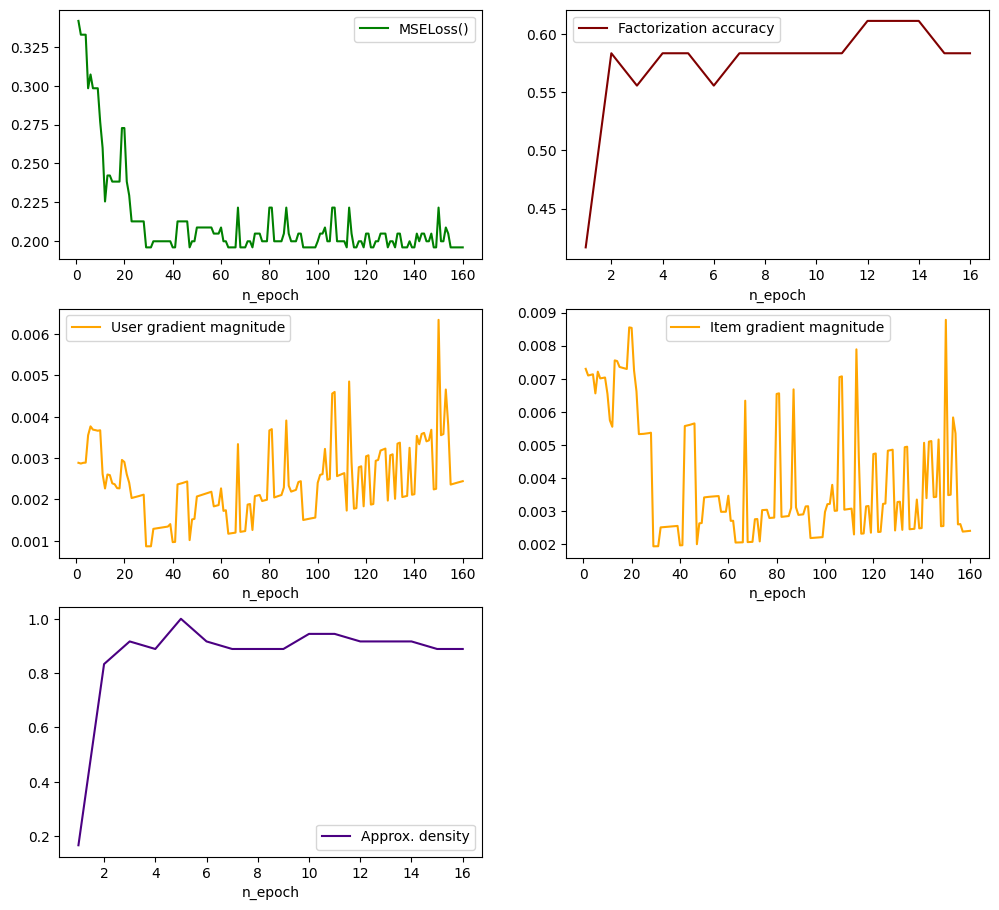

In [61]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=36, n_epochs=160,
    draw_plots=True              
)